# MACHINE LEARNING FOR CHAOTIC TIME SERIES

In [1]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# Resampling Dictionary
ohlc_dict = {
'open':'first',
'high':'max',
'low':'min',
'close':'last',
'volume':'sum',
'time':'first',
'date':'first'
}

## Fetching BANKNIFTY index price data

In [3]:
# Read Price Data from CSV
price_data_raw = pd.read_csv('/home/blackrose/Blackprint/Data/NIFTYBANK_1m.csv')
# Adjust column order
price_data_raw = price_data_raw['date open high low close volume'.split()]
# Rename columns
price_data_raw.columns = 'datetime open high low close volume'.split()
# Remove +5:30 extension from timestamp strings
price_data_raw['datetime'] = price_data_raw['datetime'].apply(lambda x: x.split('+')[0])
# Convert timestamp strings to datetime objects
price_data_raw['datetime'] = price_data_raw['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# Create column of time values
price_data_raw['time'] = price_data_raw['datetime'].apply(lambda x: x.time())
# Create column of date values
price_data_raw['date'] = price_data_raw['datetime'].apply(lambda x: x.date())
# Set datetime column as index
price_data_raw.set_index('datetime', inplace=True)

In [4]:
# Create working copy of raw price data
price_data = price_data_raw.loc['2015-01-01':].copy().dropna()
# Resample 1min prices to 15min
price_data = price_data.resample('15min', closed='left', label='left').apply(ohlc_dict).dropna()

______

## Analysing data for chaotic behavior

**Nolds:** is a library that provides numpy-based implementation for nonlinear measures of dynamical systems based on one-dimensional time series.

In [5]:
import nolds

In [6]:
# Select part of the in sample price data 
subset = price_data['close'].iloc[:int(len(price_data)*0.3)].values

### Lyapunov Exponent

MLE: Maximum Lyapunov Exponent

* **MLE > 0:** Data suggests system is chaotic
* **MLE < 0:** Data suggests system is not chaotic

In [7]:
nolds.lyap_e(subset)[0]

0.14416279

### Hurst Exponent

* **HE > 0.5:** Positive Long-Term Correlation
* **HE ~= 0.5:** No Long-Term Correlation
* **HE < 0.5:** Negative Long-Term Correlation

In [8]:
nolds.hurst_rs(subset)

0.9586167377535618

________

## Data Features

**Input:** Closing prices of last 3 hours at 15 minute intervals.

**Target:** Price of instrument 15 mins from now.

In [9]:
# Create input Variable Columns by shifting past price data into single row.
price_data['close-1'] = price_data['close'].shift()
price_data['close-2'] = price_data['close'].shift(2)
price_data['close-3'] = price_data['close'].shift(3)
price_data['close-4'] = price_data['close'].shift(4)
price_data['close-5'] = price_data['close'].shift(5)
price_data['close-6'] = price_data['close'].shift(6)
price_data['close-7'] = price_data['close'].shift(7)

# Create Target/Output Variable Columns by shifting price data into previous row.
price_data['close+1'] = price_data['close'].shift(-1)

In [10]:
# Select input & target variable columns
price_data = price_data['close close-1 close-2 close-3 close-4 close-5 close-6 close-7 close+1'.split()].copy()

In [11]:
# Remove NaNs from price data
price_data = price_data.dropna()

In [12]:
price_data.head()

,close,close-1,close-2,close-3,close-4,close-5,close-6,close-7,close+1
datetime,,,,,,,,,
2015-01-09 11:00:00,18779.35,18778.30,18764.00,18803.00,18781.15,18802.90,18771.60,18815.15,18734.15
2015-01-09 11:15:00,18734.15,18779.35,18778.30,18764.00,18803.00,18781.15,18802.90,18771.60,18699.65
2015-01-09 11:30:00,18699.65,18734.15,18779.35,18778.30,18764.00,18803.00,18781.15,18802.90,18715.30
2015-01-09 11:45:00,18715.30,18699.65,18734.15,18779.35,18778.30,18764.00,18803.00,18781.15,18616.35
2015-01-09 12:00:00,18616.35,18715.30,18699.65,18734.15,18779.35,18778.30,18764.00,18803.00,18585.55


In [13]:
# Convert dataframe to numpy array
data = price_data.values
# Lenght of input data
inputLength = len(data)
# Train/Test Split: 70/30
trainingLength = int(inputLength*0.7)

In [14]:
# Create array of input data
inputData = data[:, :8]
# Create array of output data
outputData = data[:, 8]
# Reshape 
outputData = outputData.reshape(len(outputData), 1)

# Split input data into training and validation sets
inputDataTraining = inputData[:trainingLength]
inputDataValidation = inputData[trainingLength:]

# Split output data into training and validation sets
outputDataTraining = outputData[:trainingLength]
outputDataValidation = outputData[trainingLength:]

________

## Building an Echo State Network

**EasyESN:** is a library for echo state networks with a high level easy to use API similar to sklearn.

In [15]:
from easyesn import PredictionESN

Using Numpy backend.


In [16]:
### Initialize model of Prediction ESN class ###
# Inputs = 8
# Output = 1
# Reservoir Nodes = 800
# Leaking Rate = 0.2
# Regression Params = 1e-2
# Solver = Least Squares
# Feedback = False
# Input Scaling = Yes

esn = PredictionESN(n_input=8, n_output=1, n_reservoir=800, leakingRate=0.2, solver="lsqr", feedback=False, inputScaling=1, regressionParameters=[1e-2])

In [17]:
### Train the ESN
# Transient Time = Auto
# Verbose = 1
esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)

100% (20622 of 20622) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


42.309269982392856

In [18]:
# Create one step prediction on training data
one_step_prediction = esn.predict(inputDataValidation)

In [19]:
# Create Series out of sample price data into
oos = pd.Series(outputDataValidation.T[0])
# Create Series of the one setop predictions
prediction = pd.Series(one_step_prediction.T[0])
# Compute forecast as difference between prediction and current price
forecast = (prediction - oos.shift())
# If forecast suggests up move, go long
longs = (oos[forecast > 0] - oos.shift()[forecast > 0])
# If forecast suggest down move, go short
shorts = (- oos[forecast < 0] + oos.shift()[forecast < 0])
# Combine long and short trades into single pandas Series
trades = pd.concat([longs, shorts], axis=1).fillna(0).sum(axis=1)

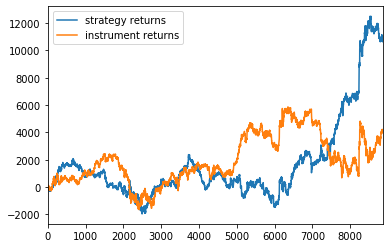

In [20]:
# Create plot of trade returns
trades.cumsum().plot()
# Create plot of out of sample returns
oos.diff().cumsum().plot()
# Plot legend
plt.legend(['strategy returns', 'instrument returns'])

____

# THANK YOU! :D

### Email: vihan13singh@gmail.com

### Company Website: www.blackrose.tech/

### Company Email: contact@blackrose.tech

### Phone No. : +91-9810171088

### Twitter: @vihan13singh

### Github: www.github.com/vihan13singh